# Predicción sobre AL2-FIUNA mediante regresion logistica



---


Estudiantes:

*   Marcos Ibañez
*   Hugo Melgarejo

**Librerías a utilizar**

In [1]:
#Importamos las librerias de pandas,numpy,matplotlib y sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.weightstats import ttest_ind
import seaborn as sns
from math import ceil
from collections import Counter
from imblearn.under_sampling import NearMiss 


# Base de datos, desde GitHub

In [2]:
#Importamos nuestra base de datos
url = 'https://raw.githubusercontent.com/diegostaPy/cursoIA/main/datosRendimiento/datosfiltrados.csv'
df = pd.read_csv(url)
df.head()


,ix,Id,danho,ciclo,Cod.Asign,Asignatura,Cod.Car.Sec,Cod.Curso,Convocatoria,Anho,Semestre,Aprobado,Anho.Firma,Primer.Par,Segundo.Par,AOT,Primer.Rec,Segundo.Rec,Nota.Final,id_anony
0,135020,503,2017,1,13008,CALCULO 2,ELE-PLS13,2,1,2017,1,N,0,7,0,0,0,0,NaN,es_1444
1,135021,504,2017,1,13008,CALCULO 2,CGF-PLS13,2,1,2017,1,N,0,5,0,0,0,0,NaN,es_4238
2,135022,505,2017,1,13008,CALCULO 2,ELE-PLS13,2,1,2017,1,S,2016,0,0,0,0,0,"1F-1,2F-2",es_4245
3,135023,506,2017,1,13008,CALCULO 2,CIV-PLS13,2,1,2017,1,N,0,0,0,0,0,0,NaN,es_4967
4,135024,507,2017,1,13008,CALCULO 2,CGF-PLS13,2,1,2017,1,S,2017,21,10,0,0,0,3F-C-3,es_414


# Pre-procesamiento
Creamos una copia, luego extraemos las columnas que consideramos son útiles a para nuestra predicción de la materia que corresponde.

In [3]:
#Creamos una copia del dataframe
dfcopia = df.copy()

dfcopia= dfcopia[dfcopia['Asignatura']=='ALGEBRA LINEAL 2']

#dfcopia=dfcopia.set_index('id_anony')
#cols= ['Convocatoria','Anho','Aprobado','Anho.Firma','Primer.Par','Segundo.Par','AOT']
cols= ['Aprobado','Primer.Par','Segundo.Par']
dfcopia=dfcopia[cols]
#dfcopia['Semestre']=df['Semestre']
dfcopia



,Aprobado,Primer.Par,Segundo.Par
451,N,0,0
452,N,4,19
453,N,3,0
454,N,3,1
455,N,4,19
...,...,...,...
15862,N,4,0
15863,S,18,29
15864,N,7,0
15865,N,7,18


Reemplazamos en la columna 'Aprobado' los S y N por 1 y 0 respectivamente.

In [4]:
dfcopia['Aprobado']=dfcopia['Aprobado'].replace(['S', 'N'],['1','0'])
dfcopia

,Aprobado,Primer.Par,Segundo.Par
451,0,0,0
452,0,4,19
453,0,3,0
454,0,3,1
455,0,4,19
...,...,...,...
15862,0,4,0
15863,1,18,29
15864,0,7,0
15865,0,7,18


# Definición de entradas y salidas
Examinando el dataset, encontramos que el taller no se carga los primeros años, por lo que para un primer approach consideramos las notas del primer parcial y segundo parcial como entradas.

# Graficamos los datos

In [5]:
X = dfcopia[['Primer.Par','Segundo.Par']]
Y = dfcopia[['Aprobado']]
X2 = dfcopia[['Primer.Par','Segundo.Par']].values
Y2 = dfcopia[['Aprobado']].values



<function matplotlib.pyplot.show(close=None, block=None)>

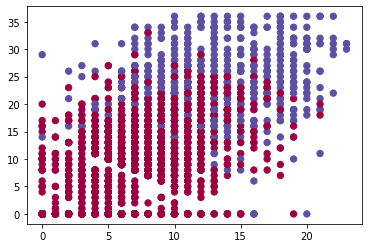

In [6]:
plt.scatter(X2[:,0],X2[:,1],s=40,c=Y2,cmap=plt.cm.Spectral)
plt.show

Verificamos si esta o no desbalanceado


In [7]:
Y.Aprobado.value_counts().sort_index()

0    1680
1     904
Name: Aprobado, dtype: int64

Aqui notamos que está notablemente desbalanceado

#Separación de datos en partes de entrenamiento y de test

Se escoge un tamaño de test del 20%

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state = 1234,shuffle = True)
Y_train.Aprobado.value_counts().sort_index()


0    1366
1     701
Name: Aprobado, dtype: int64

Para balancear la muestra de entrenamiento será necesario recurrir a metodos de balanceo, como podría ser los disponibles en la librería NearMiss.

In [9]:
from collections import Counter
us = NearMiss(n_neighbors=3, version=2)
X_train_res, Y_train_res = us.fit_resample(X_train, Y_train)

print ("Distribucion antes del resampling {}".format(Counter(Y_train['Aprobado'])))
print ("Distribucion despues del resampling {}".format(Counter(Y_train_res)))


Distribucion antes del resampling Counter({'0': 1366, '1': 701})
Distribucion despues del resampling Counter({'Aprobado': 1})


Se implementa el modelo de Regresión Logística, se lo entrena y se lo testea.

In [10]:
algoritmo = LogisticRegression()
#Entrenamos el modelo
algoritmo.fit(X_train_res,Y_train_res)
#Realizamos la prediccion
Y_pred = algoritmo.predict(X_test)

D:\Anaconda\envs\Inteligencia_Artificial\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


#Métricas
**Matriz de confusión**

In [11]:
from sklearn.metrics import confusion_matrix
matriz = confusion_matrix(Y_test,Y_pred)
print(matriz)


[[279  35]
 [ 41 162]]


<AxesSubplot:>

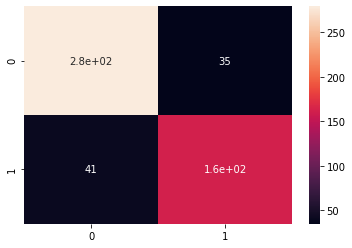

In [12]:
import seaborn as sns
sns.heatmap(matriz, annot=True)

**Precisión**

In [13]:
#Calculamos la precision del modelo
from sklearn.metrics import precision_score
precision = precision_score(Y_test, Y_pred, average="binary", pos_label='1') 
print('Precisión del modelo:')
print(precision)

Precisión del modelo:
0.8223350253807107


**Reporte del modelo**


In [14]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       314
           1       0.82      0.80      0.81       203

    accuracy                           0.85       517
   macro avg       0.85      0.84      0.85       517
weighted avg       0.85      0.85      0.85       517



#Resultados



In [15]:
#Mostramos el nro de secciones predicho por el modelo
print('Numero de secciones:')
secc = (Y_pred[Y_pred == '0'].size)/60
print(ceil(secc))




Numero de secciones:
6
